In [140]:
import numpy as np
import lightgbm as lgb
import shap
from sklearn.preprocessing import PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression

#===================================================================
# Make small data
#===================================================================

def make_data(n=100):
    x1 = np.linspace(0.01, 1, n)
    x2 = np.log(x1)
    x3 = x1 > 0.7
    X = np.column_stack((x1, x2, x3))

    y = 1 + 0.2 * x1 + 0.5 * x2 + x3 + np.sin(2 * np.pi * x1)
    
    return X, y

X, y = make_data()

#===================================================================
# Additive linear model and additive boosted trees
#===================================================================

# Linear model with polynomial terms
poly = PolynomialFeatures(degree=3, include_bias=False)

preprocessor =  ColumnTransformer(
    transformers=[
        ("poly0", poly, [0]),
        ("poly1", poly, [1]),
        ("other", "passthrough", [2]),
    ]
)

model_lm = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("lm", LinearRegression()),
    ]
)
_ = model_lm.fit(X, y)

# Boosted trees with single-split trees
params = dict(
    learning_rate=0.05,
    objective="mse",
    max_depth=1,
    colsample_bynode=0.7,
)

model_lgb = lgb.train(
    params=params,
    train_set=lgb.Dataset(X, label=y),
    num_boost_round=300,
)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000172 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 71
[LightGBM] [Info] Number of data points in the train set: 100, number of used features: 3
[LightGBM] [Info] Start training from score 0.927112


## Three different types of SHAP for the two models

In [144]:
shap_lm = {
    "add": shap.Explainer(model_lm.predict, masker=X, algorithm="additive")(X),
    "perm": shap.Explainer(model_lm.predict, masker=X, algorithm="exact")(X),
    "kern": shap.KernelExplainer(model_lm.predict, data=X).shap_values(X),
}

shap_lgb = {
    "tree": shap.Explainer(model_lgb)(X),
    "perm": shap.Explainer(model_lgb.predict, masker=X, algorithm="exact")(X),
    "kern": shap.KernelExplainer(model_lgb.predict, data=X).shap_values(X),
}

# Consistency for additive linear regression
eps = 1e-12
assert np.abs(shap_lm["add"].values - shap_lm["perm"].values).max() < eps
assert np.abs(shap_lm["perm"].values - shap_lm["kern"]).max() < eps

# Consistency for additive boosted trees
assert np.abs(shap_lgb["tree"].values - shap_lgb["perm"].values).max() < eps
assert np.abs(shap_lgb["perm"].values - shap_lgb["kern"]).max() < eps

# Linear effect of last feature in the fitted model
model_lm.named_steps["lm"].coef_[-1]  # 1.112096

# Linear effect of last feature derived from SHAP values (ignore the sign)
shap_lm["perm"][:, 2].values.ptp()    # 1.112096

100%|██████████| 100/100 [00:02<00:00, 34.25it/s]


1.1120960951602015

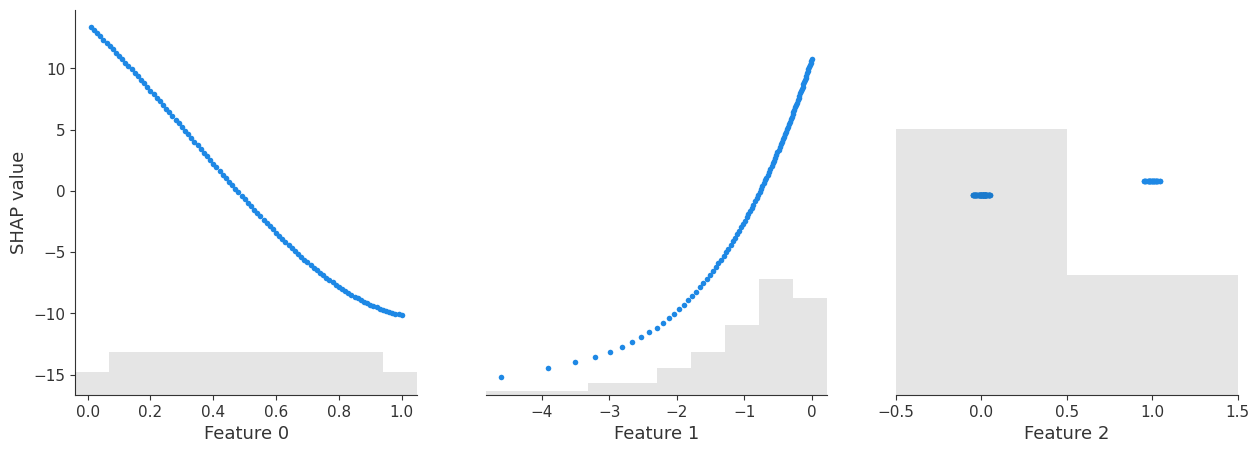

In [150]:
shap.plots.scatter(shap_lm["add"])